This is the first chapter of the multimodal single-cell gene expression and chromatin accessibility analysis. In this notebook, scRNA-seq data processing is described, largely following [this scanpy notebook](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) on processing and clustering PBMCs.

In [1]:
# Change directory to the root folder of the repository
import os
os.chdir("../../")

# Download data

Download the data that we will use for this series of notebooks. [The data is available here](https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k).

For the tutorial, we will use the following files:

1. Filtered feature barcode matrix (HDF5)
1. ATAC peak annotations based on proximal genes (TSV)
1. ATAC Per fragment information file (TSV.GZ)
1. ATAC Per fragment information index (TSV.GZ index)

In [2]:
# This is the directory where those files are downloaded to
data_dir = "data/pbmc10k"

In [3]:
# Remove file prefixes if any
for file in os.listdir(data_dir):
    new_filename = file.lstrip("pbmc_unsorted_10k_")
    os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

# Load libraries and data

Import libraries:

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [5]:
import muon as mu

Load gene and peak counts:

In [6]:
mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_feature_bc_matrix.h5"))
mdata.var_names_make_unique()
mdata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from data/pbmc10k/filtered_feature_bc_matrix.h5


/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.


Added peak annotation from data/pbmc10k/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: data/pbmc10k/atac_fragments.tsv.gz


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


MuData object with n_obs × n_vars = 12016 × 100352
  var:	'rna/gene_ids', 'rna/feature_types', 'rna/genome', 'rna/interval', 'atac/gene_ids', 'atac/feature_types', 'atac/genome', 'atac/interval'
  2 modalities
    rna:	12016 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	12016 x 63751
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

Muon uses multimodal data (MuData) objects as containers for multimodal data.

`mdata` here is a MuData object that has been created directly from an AnnData object with multiple features types.

# RNA

In this notebook, we will only work with the Gene Expression modality.

We can refer to an individual AnnData inside the MuData by defining a respective variable. All the operations will be performed on the respective AnnData object inside the MuData as you would expect.

In [7]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 12016 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

## Preprocessing

### QC

Perform some quality control. For now, we will filter out cells that do not pass QC.

In [8]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Some mild pre-filtering:

In [9]:
sc.pp.filter_cells(rna, min_genes=200)
sc.pp.filter_genes(rna, min_cells=3)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical


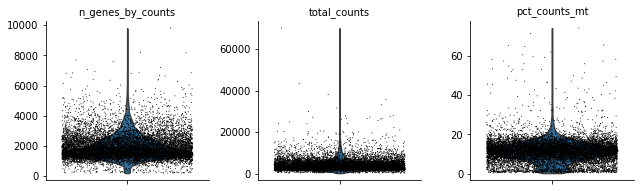

In [10]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [11]:
rna = rna[rna.obs.n_genes_by_counts < 5000, :]
rna = rna[rna.obs.total_counts < 15000, :]
rna = rna[rna.obs.pct_counts_mt < 20, :]

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Let's see how the data looks after filtering:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


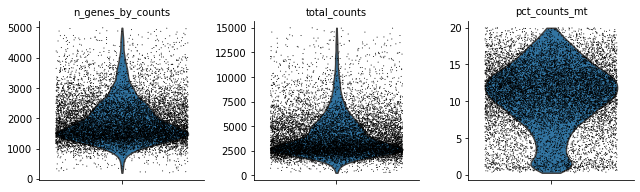

In [12]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Normalisation

We'll normalise the data so that we get log-normalised counts to work with.

In [13]:
sc.pp.normalize_total(rna, target_sum=1e4)

/usr/local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.pp.log1p(rna)

### Feature selection

We will label highly variable genes that we'll use for downstream analysis.

In [15]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

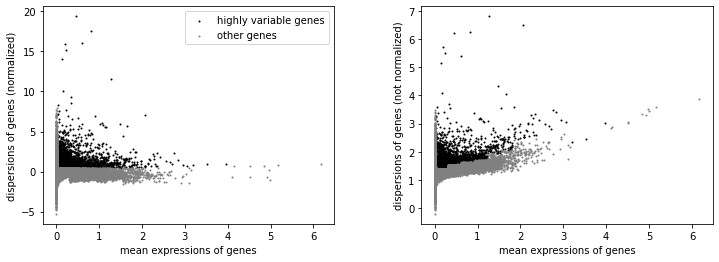

In [16]:
sc.pl.highly_variable_genes(rna)

In [17]:
np.sum(rna.var.highly_variable)

3902

### Scaling

We'll save log-normalised counts in a `.raw` slot:

In [18]:
rna.raw = rna

... and scale the log-normalised counts to zero mean and unit variance:

In [19]:
sc.pp.scale(rna, max_value=10)

## Analysis

Having filtered low-quality cells, normalised the counts matrix, and performed feature selection, we can already use this data for multimodal integration.

However it is usually a good idea to study individual modalities as well.
Below we run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types.

### PCA and neighbourhood graph

In [20]:
sc.tl.pca(rna, svd_solver='arpack')

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


To visualise the result, we will use some markers for (large-scale) cell populations we expect to see such as T cells and NK cells (CD2), B cells (CD79A), and KLF4 (monocytes).

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


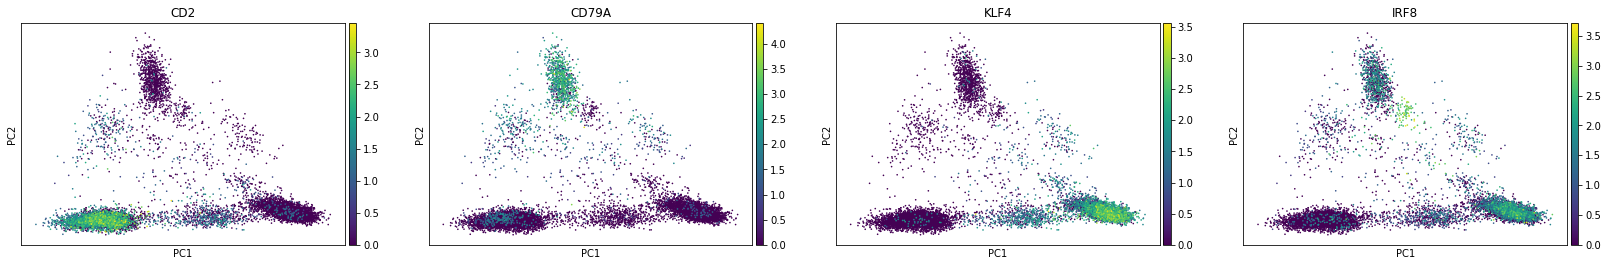

In [21]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

The first principal component (PC1) is separating myeloid (monocytes) and lymphoid (T, B, NK) cells while B cells-related features seem to drive the second one. Also we see plasmocytoid dendritic cells (marked by IRF8) being close to B cells along the PC2.

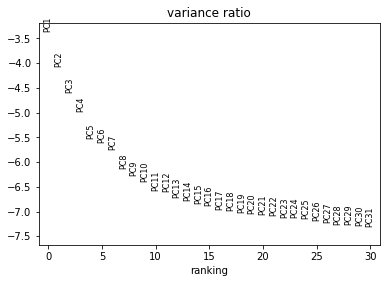

In [22]:
sc.pl.pca_variance_ratio(rna, log=True)

Now we can compute a neighbourhood graph for cells:

In [23]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

### Non-linear dimensionality reduction and clustering

With the neighbourhood graph computed, we can now perform clustering. We will use `leiden` clustering as an example.

In [24]:
sc.tl.leiden(rna, resolution=.3)

To visualise the results, we'll first generate a 2D latent space with cells that we can colour according to their cluster assignment.

In [25]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=10)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


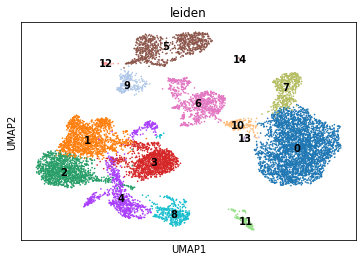

In [26]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

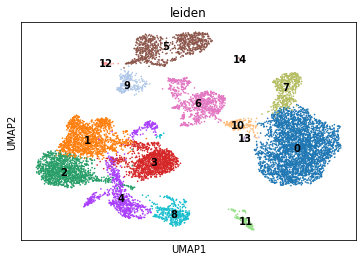

In [27]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

### Marker genes and celltypes

In [28]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

In [29]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p
0,PLXDC2,0.0,INPP4B,0.000000e+00,LEF1,0.000000e+00,LEF1,0.000000e+00,CCL5,1.071881e-289,BANK1,0.000000e+00,PLXDC2,2.766973e-280,TCF7L2,0.000000e+00,GNLY,1.655771e-222,BANK1,5.440243e-171,CD74,9.934706e-107,TCF4,1.640756e-104,PPIB,4.792393e-21,S100A9,3.349092e-10,RPL34,1.582157e-10
1,FCN1,0.0,ARHGAP15,0.000000e+00,BCL11B,0.000000e+00,BACH2,0.000000e+00,NKG7,6.848722e-265,AFF3,0.000000e+00,SLC8A1,8.182427e-270,PSAP,0.000000e+00,CD247,2.098321e-195,AFF3,5.934308e-145,CST3,2.053258e-90,RUNX2,1.569814e-83,TXNDC5,8.322578e-21,RPL37A,3.954992e-10,CDK6,4.195314e-10
2,LRMDA,0.0,BCL11B,0.000000e+00,BACH2,0.000000e+00,THEMIS,0.000000e+00,PRKCH,1.835236e-289,RALGPS2,0.000000e+00,NEAT1,1.306160e-298,MTSS1,1.097085e-275,NKG7,2.175248e-172,RALGPS2,5.641855e-97,HLA-DRA,7.082927e-87,IRF8,2.045114e-81,HSP90B1,3.149412e-18,RPL39,6.104837e-09,EEF1A1,8.392193e-10
3,SLC8A1,0.0,SYNE2,0.000000e+00,CAMK4,0.000000e+00,BCL11B,0.000000e+00,SYNE2,2.622734e-252,CD74,0.000000e+00,SAT1,1.044920e-255,LYN,0.000000e+00,PRF1,7.167275e-159,MS4A1,1.723454e-94,HLA-DRB1,3.376247e-81,RHEX,6.122110e-79,DENND5B,3.528164e-18,S100A8,4.232097e-08,SOX4,3.268049e-09
4,DPYD,0.0,ANK3,2.198088e-318,FHIT,5.347069e-302,PDE3B,0.000000e+00,SKAP1,4.302668e-267,MS4A1,0.000000e+00,AOAH,3.074418e-260,CTSS,1.167995e-278,PRKCH,3.691185e-130,BACH2,6.011902e-93,HLA-DQA1,1.276197e-75,AFF3,2.858035e-83,MAN1A1,9.291729e-18,RPS18,2.580839e-07,RPS12,4.439948e-09
5,JAK2,0.0,SKAP1,5.211691e-318,ANK3,5.992765e-263,CAMK4,0.000000e+00,A2M,1.059884e-203,PAX5,0.000000e+00,ZEB2,2.450682e-233,SAT1,3.684784e-298,MCTP2,3.200218e-120,PAX5,2.162315e-85,HDAC9,4.076131e-71,APP,4.408396e-74,MZB1,4.967615e-17,ACTB,6.337379e-07,ERG,8.594972e-09
6,NEAT1,0.0,CDC14A,1.412184e-288,INPP4B,1.035523e-261,NELL2,0.000000e+00,IL32,2.837444e-204,FCRL1,0.000000e+00,DPYD,9.628744e-242,SLC8A1,1.206955e-263,GZMA,9.386576e-110,CD74,1.948451e-88,HLA-DPB1,3.057593e-69,PLD4,1.289834e-72,MYO1D,5.479502e-17,FOS,8.934985e-07,RPS6,1.132825e-08
7,VCAN,0.0,TTC39C,1.752868e-273,CD247,3.507920e-238,TXK,1.715559e-305,GNLY,1.823835e-190,IGHM,0.000000e+00,LYST,7.264400e-206,COTL1,9.682818e-229,KLRD1,2.772445e-108,FCRL1,4.800099e-77,HLA-DQB1,2.795470e-68,CCDC50,6.951140e-70,JCHAIN,9.046864e-17,RPS26,1.015527e-05,RPL27A,1.073250e-08
8,ARHGAP26,0.0,RORA,4.658204e-273,TCF7,2.412248e-226,PRKCH,4.940656e-323,GZMA,4.120662e-177,HLA-DRA,0.000000e+00,JAK2,3.504534e-200,CST3,6.476203e-220,CTSW,2.538947e-106,IGHM,6.604911e-70,AFF3,3.925133e-69,FCHSD2,2.867813e-70,SUB1,7.635818e-17,RPS29,2.310192e-05,RPS20,1.656859e-08
9,ZEB2,0.0,LTB,4.001197e-275,PRKCA,1.103056e-221,MAML2,2.135865e-309,SYNE1,1.658026e-178,LINC00926,8.250324e-281,LRMDA,2.095218e-186,TYMP,7.191760e-254,NCALD,1.208130e-103,LINC00926,4.762510e-64,HLA-DRB5,6.558563e-66,UGCG,1.688189e-66,RPS4X,4.742491e-17,RPS12,2.691806e-05,RPL11,1.871344e-08


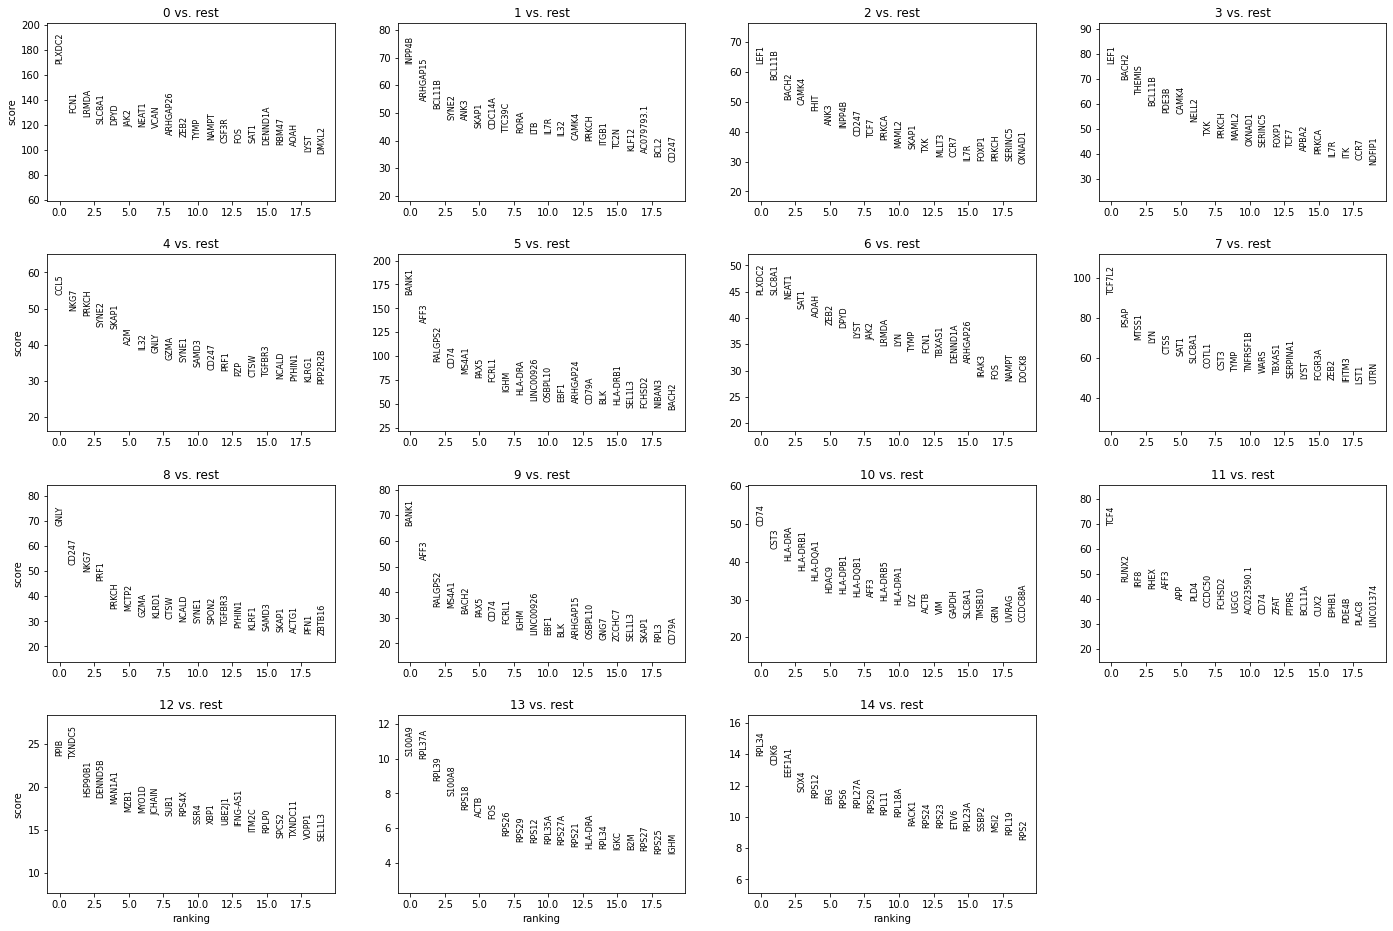

In [30]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

Exploring the data we notice clusters 6 and 9 seem to be composed of cells bearing markers for different cell lineages so likely to be noise (e.g. doublets). Cluster 13 has higher ribosomal gene expression when compared to other clusters. Cluster 14 seem to consist of proliferating cells, and cells cluster 12 might be stressed (high expression of endoplasmic reticulum-associated genes).

We will remove cells from these clusters before assigning cell types names to clusters.

In [31]:
rna = rna[~rna.obs.leiden.isin(["6", "9", "12", "13", "14"])]

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [32]:
new_cluster_names = [
    'mono CD14+', 'T CD4+ memory', 'T CD4+ naïve', 
    'T CD8+ naïve', 'T CD8+ activated', 'B', 
    'mono CD16+', 'NK', 'mDC',
    'pDC']
rna.obs['celltype'] = rna.obs.leiden.values
rna.rename_categories('celltype', new_cluster_names)

Trying to set attribute `.obs` of view, copying.


We will also re-order categories for the next plots:

In [33]:
rna.obs.celltype.cat.reorder_categories([
    'T CD4+ naïve', 'T CD4+ memory',
    'T CD8+ naïve', 'T CD8+ activated', 
    'NK', 'B',
    'mono CD14+', 'mono CD16+',
    'mDC', 'pDC'], inplace=True)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


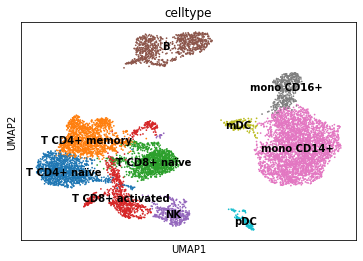

In [34]:
sc.pl.umap(rna, color="celltype", legend_loc="on data")

Finally, we'll visualise some marker genes across cell types.

In [35]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHM', 'IGHD',
                'KLF4', 'LYZ', 'S100A8', 'CD14', 
                'FCGR3A', 'MS4A7', 'CST3',
                'IRF8', 'TCF4']

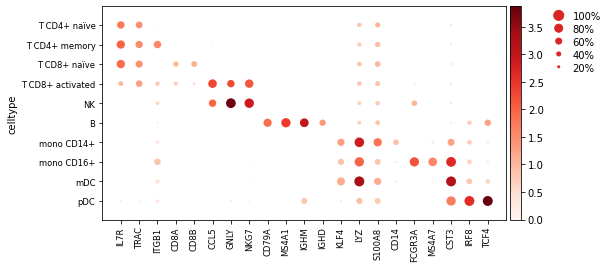

In [36]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype');

# Saving multimodal data on disk

We will now write `mdata` object to an `.h5mu` file. It will contain all the changes we've done to the RNA modality (`mdata.mod['rna']`) inside it.

In [39]:
mdata.write("data/pbmc10k.h5mu")

[Next, we'll look into processing the second modality — chromatin accessibility.](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.ipynb)
